# Solving opencast mining problem using GA

### Problem data

In [1]:
import numpy as np

# Data
BLOCKS = np.arange(0, 18) # Blocks in the mine
LEVEL23 = np.array([8, 9, 10, 11, 12, 13, 14, 15, 16, 17]) # Blocks in level 2 and 3
COST = np.array([100, 100, 100, 100, 100, 100, 100, 100,
                 200, 200, 200, 200, 200, 200, 
                 1000, 1000, 1000, 1000]) # Cost of blocks

VALUE = np.array([200, 0, 0, 0, 0, 0, 300, 0, 
                  0, 500, 0, 200, 0, 0, 
                  0, 0, 1000, 0]) # Value of blocks

# Define the ARC for each block in LEVEL23
Precedence = np.array([[0,1, 2],
                [1, 2, 3],
                [2, 3, 4],
                [3, 4, 5],
                [4, 5, 6],
                [5, 6, 7],
                [8, 9, 10],
                [9, 10, 11],
                [10, 11, 12],
                [11, 12, 13]])

### Visualize precedence graph

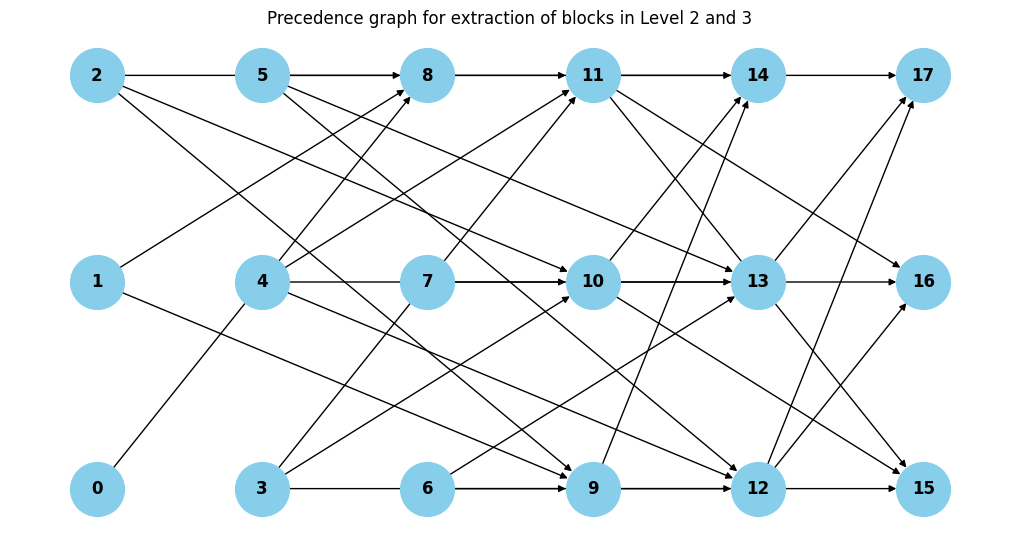

In [2]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt

# Create the directed graph
G = nx.DiGraph()

# Add nodes
G.add_nodes_from(BLOCKS)

# Add precedence edges
for b, arc in zip(LEVEL23, Precedence):
    for predecessor in arc:
        G.add_edge(predecessor, b)

# create pos dictionary with default position for all nodes
pos = nx.spring_layout(G)

# update position of nodes that have a specific position
pos.update({0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (1, 0), 4: (1, 1), 5: (1, 2), 6: (2, 0), 7: (2, 1), 
            8: (2, 2), 9: (3, 0), 10: (3, 1), 11: (3, 2), 12: (4, 0), 13: (4, 1), 
            14: (4, 2), 15: (5, 0), 16: (5, 1), 17: (5, 2)})


# Draw the graph
plt.figure(figsize=(10, 5))
nx.draw(G, pos, with_labels=True, node_size=1500, node_color='skyblue', font_size=12, font_weight='bold')
plt.title("Precedence graph for extraction of blocks in Level 2 and 3")
plt.show()

### Define the single objective optimization problem (SOP)

In [3]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.pntx import PointCrossover
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

In [4]:
# Problem definition
class OpencastMiningProblem(Problem):
    def __init__(self):
        super().__init__(n_var=18, n_obj=1, n_constr=len(LEVEL23), xl=0, xu=1)

    def _evaluate(self, X, out, *args, **kwargs):
        X = np.round(X)  # Ensure X is binary
        profits = np.sum((VALUE - COST) * X, axis=1)

        constraints = np.zeros((X.shape[0], len(LEVEL23)))
        for i in range(X.shape[0]):
            for j, b in enumerate(LEVEL23):
                constraints[i, j] = min(X[i, Precedence[j]-1]) - X[i, b-1]

        out["F"] = profits.reshape(-1, 1)
        out["G"] = constraints

### Define the GA solver and apply it to solve the problem

In [5]:
problem = OpencastMiningProblem()

algorithm = GA(
    pop_size=50,
    sampling=FloatRandomSampling(),
    crossover=PointCrossover(prob=0.8, n_points=2),
    mutation = PolynomialMutation(prob=0.3, repair=RoundingRepair()),
    eliminate_duplicates=True
)

res = minimize(problem, algorithm, ('n_gen', 50), seed=1, verbose=True)

print("Best solution found:\nX =", res.X)
print("Objective value =", -res.F[0])  # Convert back to maximization problem

n_gen  |  n_eval  |     cv_min    |     cv_avg    |     f_avg     |     f_min    
     1 |       50 |  0.000000E+00 |  0.6800000000 | -2.315625E+03 | -3.800000E+03
     2 |      100 |  0.000000E+00 |  0.000000E+00 | -2.882000E+03 | -4.100000E+03
     3 |      150 |  0.000000E+00 |  0.000000E+00 | -3.424000E+03 | -4.100000E+03
     4 |      200 |  0.000000E+00 |  0.000000E+00 | -3.718000E+03 | -4.200000E+03
     5 |      250 |  0.000000E+00 |  0.000000E+00 | -3.872000E+03 | -4.300000E+03
     6 |      300 |  0.000000E+00 |  0.000000E+00 | -3.996000E+03 | -4.300000E+03
     7 |      350 |  0.000000E+00 |  0.000000E+00 | -4.076000E+03 | -4.300000E+03
     8 |      400 |  0.000000E+00 |  0.000000E+00 | -4.114000E+03 | -4.300000E+03
     9 |      450 |  0.000000E+00 |  0.000000E+00 | -4.158000E+03 | -4.300000E+03
    10 |      500 |  0.000000E+00 |  0.000000E+00 | -4.168000E+03 | -4.300000E+03
    11 |      550 |  0.000000E+00 |  0.000000E+00 | -4.172000E+03 | -4.300000E+03
    12 |      60

# Solving opencast mining using NSGA-II

In [6]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.visualization.scatter import Scatter
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination import get_termination
from pymoo.decomposition.asf import ASF

In [7]:
TIME = np.array([1, 1, 1, 1, 1, 1, 1, 1, 
                 3, 2, 2, 2, 2, 3, 
                 4, 4, 3, 4]) # Opearting time

### Define the problem as a multi-objective optimization problem (MOP)

In [8]:
discount_rate=0.1

class OpencastMiningProblem_Pareto(Problem):
    def __init__(self):
        super().__init__(n_var=18, n_obj=2, n_constr=len(LEVEL23), xl=0, xu=1)

    def _evaluate(self, X, out, *args, **kwargs):
        X = np.round(X)  # Ensure X is binary
        f1=-np.sum((VALUE-COST)/((1 + discount_rate)**TIME) * X, axis=1) # discounted profit
        # f1=-np.sum((VALUE-COST)*(np.exp(-discount_rate*TIME)) * X, axis=1) # another formula of discounted profit
        f2=np.sum((COST*(1 + 2*TIME))*X, axis=1) # increased cost

        constraints = np.zeros((X.shape[0], len(LEVEL23)))
        for i in range(X.shape[0]):
            for j, b in enumerate(LEVEL23):
                constraints[i, j] = min(X[i, Precedence[j]-1]) - X[i, b-1]

        out["F"] = [f1, f2] 
        out["G"] = constraints

### Define the NSGA-II solver and apply it 

In [9]:
problem = OpencastMiningProblem_Pareto()

algorithm = NSGA2(
    pop_size=50,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 100)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       50 |      1 |  0.000000E+00 |  0.6800000000 |             - |             -
     2 |       60 |      1 |  0.000000E+00 |  0.2000000000 |  0.000000E+00 |             f
     3 |       70 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     4 |       80 |      2 |  0.000000E+00 |  0.000000E+00 |  1.0000000000 |         ideal
     5 |       90 |      3 |  0.000000E+00 |  0.000000E+00 |  0.1923076923 |         ideal
     6 |      100 |      2 |  0.000000E+00 |  0.000000E+00 |  0.7142857143 |         ideal
     7 |      110 |      2 |  0.000000E+00 |  0.000000E+00 |  0.2307692308 |         ideal
     8 |      120 |      3 |  0.000000E+00 |  0.000000E+00 |  0.5666666667 |         ideal
     9 |      130 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0606060606 |         ideal
    10 |      140 |      3 |  0.000000E+00 |  0.000000E+00 |  8.9000000000 |         nadir

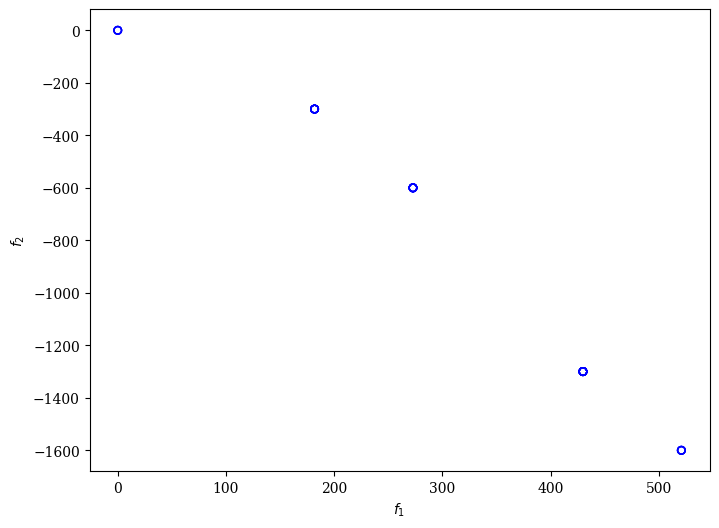

In [10]:
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(-res.F, facecolor="none", edgecolor="blue", s=30, alpha=0.8)
plot.show()

### Augmented Scalarization Function (ASF)

In [11]:
F = -res.F

approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

In [12]:
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)

In [13]:
weights = np.array([0.2, 0.8]) # weights for f1 and f2

In [14]:
decomp = ASF()

i = decomp.do(nF, 1/weights).argmin()

Best regarding ASF: Point 
i = 3
F = [  429.75206612 -1300.        ]


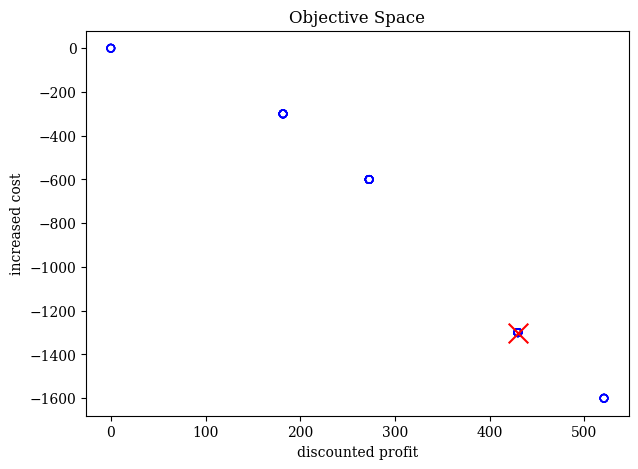

In [15]:
print("Best regarding ASF: Point \ni = %s\nF = %s" % (i, F[i]))

plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(F[i, 0], F[i, 1], marker="x", color="red", s=200)
plt.title("Objective Space")
plt.xlabel("discounted profit")
plt.ylabel("increased cost")
plt.show()